## Ingestion of manual annotations of the HLCA and removal of low QC cells:

In this notebook we add the manual annotations of the HLCA clusters to the HLCA object, and we will remove cells that were annotated as low quality (e.g. high mitochondrial count clusters, doublets, etc.). We will also do a comparison of original versus final (manual) annotations. 

### Import modules and set paths:

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import sys

sys.path.append("../../scripts/")
import reference_based_harmonizing

For pretty code formatting (not necessary to run):

In [3]:
%load_ext lab_black

Figure parameters:

In [2]:
sc.set_figure_params(figsize=(5, 5))

Paths:

In [5]:
path_input_HLCA = "../../data/HLCA_core_h5ads/HLCA_v1_intermediates/LCA_Bano_Barb_Jain_Kras_Lafy_Meye_Mish_MishBud_Nawi_Seib_Teic_log1p.h5ad"
path_output_HLCA = "../../data/HLCA_core_h5ads/HLCA_v1.h5ad"
path_manual_anns = "../../supporting_files/celltype_reannotation/manual_cluster_annotation_20210820.csv"
path_celltype_ref_mapping = "../../supporting_files/metadata_harmonization/HLCA_cell_type_reference_mapping_20211103.csv"
path_man_anns_levd_and_colors = "../../supporting_files/celltype_structure_and_colors/manual_anns_and_leveled_anns_ordered.csv"
path_grouped_man_anns_levd_and_colors = "../../supporting_files/celltype_structure_and_colors/manual_anns_grouped_order_and_colors.csv"

### Add manual annotations to HLCA:

import atlas:

In [4]:
adata_full = sc.read(path_input_HLCA)

In [7]:
adata_full

AnnData object with n_obs × n_vars = 587218 × 28527
    obs: 'sample', 'original_celltype_ann', 'study_long', 'study', 'last_author_PI', 'subject_ID', 'subject_ID_as_published', 'pre_or_postnatal', 'age_in_years', 'age_range', 'sex', 'ethnicity', 'mixed_ethnicity', 'smoking_status', 'smoking_history', 'BMI', 'known_lung_disease', 'condition', 'subject_type', 'cause_of_death', 'sample_type', 'anatomical_region_coarse', 'anatomical_region_detailed', 'tissue_dissociation_protocol', 'cells_or_nuclei', 'single_cell_platform', "3'_or_5'", 'enrichment', 'sequencing_platform', 'reference_genome_coarse', 'ensembl_release_reference_genome', 'cell_ranger_version', 'disease_status', 'fresh_or_frozen', 'cultured', 'cell_viability_%', 'comments', 'Processing_site', 'dataset', 'anatomical_region_level_1', 'anatomical_region_level_2', 'anatomical_region_level_3', 'anatomical_region_highest_res', 'age', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'ann_highest_res', 'ann_n

import manual annotations of clusters:

In [10]:
manual_annot_raw = pd.read_csv(path_manual_anns)

import cell type reference:

In [11]:
harmonizing_df = reference_based_harmonizing.load_harmonizing_table(path_celltype_ref_mapping)
consensus_df = reference_based_harmonizing.create_consensus_table(harmonizing_df)

update harmonized *original* annotations in the atlas (These are not the final manual annotations!!). This is only necessary if the cell type mapping has changed.

In [12]:
celltype_translation_df = (
    reference_based_harmonizing.create_orig_ann_to_consensus_translation_df(
        adata_full, consensus_df, harmonizing_df, verbose=False
    )
)

In [ ]:
adata_full = reference_based_harmonizing.consensus_annotate_anndata(
    adata_full, celltype_translation_df, verbose=True
)

In [13]:
adata_full = reference_based_harmonizing.add_clean_annotation(adata_full)

pre-process manual annotation table:

In [14]:
# pre-process manual annotation dataframe:
manual_annot = pd.DataFrame(index=manual_annot_raw.index)
# store the highest cluster level for each row
manual_annot["cl_level"] = np.sum(
    ~pd.isnull(manual_annot_raw.loc[:, [f"Leiden {lev}" for lev in range(1, 6)]]),
    axis=1,
)
# store the matching cluster name:
manual_annot["cl"] = [
    manual_annot_raw.loc[row, f"Leiden {lev}"]
    for row, lev in zip(manual_annot.index, manual_annot["cl_level"])
]
# and the matching final annotation:
manual_annot["final_ann"] = manual_annot_raw["Final annotation"]
# and the matching coarse annotations:
manual_annot["final_ann_coarse"] = manual_annot_raw["Coarse final annotation"]

convert final annotations to matching leveled annotations (level 1-5):

In [15]:
final_ann_set = manual_annot.final_ann.unique()
final_anns_to_leveled_anns_df = pd.DataFrame(
    index=final_ann_set, columns=[f"Level_{num}" for num in range(1, 6)] + ["ordering"]
)


def find_matching_leveled_ann(final_ann):
    return [ann for ann in consensus_df.index if ann[2:] == final_ann]


final_ann_to_leveled_ann = {
    final_ann: find_matching_leveled_ann(final_ann) for final_ann in final_ann_set
}

check where there's no translation, or two translations available (something is wrong there, unless these are clusters to be discarded, e.g. doublets):

In [16]:
for final_ann, leveled_anns in final_ann_to_leveled_ann.items():
    if len(leveled_anns) == 0:
        print(
            final_ann, leveled_anns, "(setting translation to 'Unicorns_and_artefacts')"
        )
        final_ann_to_leveled_ann[final_ann] = "Unicorns_and_artefacts"
    elif len(leveled_anns) > 1:
        print(final_ann, leveled_anns)
        print(
            "THIS NEEDS TO BE FIXED!!! This annotation is present at more than 1 level in the reference!!"
        )
        final_ann_to_leveled_ann[final_ann] = leveled_anns[0]
    else:
        final_ann_to_leveled_ann[final_ann] = leveled_anns[0]

HBB-contaminated [] (setting translation to 'Unicorns_and_artefacts')
Poor QC [] (setting translation to 'Unicorns_and_artefacts')
Doublets [] (setting translation to 'Unicorns_and_artefacts')
Single donor - Fibroblasts CRABP1+ NOV+ [] (setting translation to 'Unicorns_and_artefacts')


create dfs with translations of manual annotations to leveled annotations

In [17]:
for final_ann in final_anns_to_leveled_anns_df.index:
    if final_ann_to_leveled_ann[final_ann] == "Unicorns_and_artefacts":
        final_anns_to_leveled_anns_df.loc[
            final_ann, [f"Level_{num}" for num in range(1, 6)] + ["ordering"]
        ] = (["Unicorns_and_artefacts"] + 4 * ["1_Unicorns_and_artefacts"] + [1000])
    else:
        final_anns_to_leveled_anns_df.loc[
            final_ann, [f"Level_{num}" for num in range(1, 6)]
        ] = consensus_df.loc[
            final_ann_to_leveled_ann[final_ann], [f"level_{num}" for num in range(1, 6)]
        ].values
        # get row location of this annotation in consensus_df,
        # so that we can use the ordering from the consensus df:
        final_anns_to_leveled_anns_df.loc[final_ann, "ordering"] = np.where(
            consensus_df.index == final_ann_to_leveled_ann[final_ann]
        )[0][0]

sort df:

In [18]:
final_anns_to_leveled_anns_df.sort_values(by="ordering", ascending=True, inplace=True)

In [19]:
final_anns_to_leveled_anns_df.head(5)

,Level_1,Level_2,Level_3,Level_4,Level_5,ordering
Basal resting,Epithelial,Airway epithelium,Basal,Basal resting,4_Basal resting,3
Suprabasal,Epithelial,Airway epithelium,Basal,Suprabasal,4_Suprabasal,4
Deuterosomal,Epithelial,Airway epithelium,Multiciliated lineage,Deuterosomal,4_Deuterosomal,13
Multiciliated (nasal),Epithelial,Airway epithelium,Multiciliated lineage,Multiciliated,Multiciliated (nasal),15
Multiciliated (non-nasal),Epithelial,Airway epithelium,Multiciliated lineage,Multiciliated,Multiciliated (non-nasal),16


now add all this info to our adata:

store original leveled annotations under "original_ann_level_[lev number]" (these are the harmonized original annotations, and not the corrected, manual annotations)

In [20]:
adata_full.obs.columns = [
    col.replace("ann_level_", "original_ann_level_") for col in adata_full.obs.columns
]

Check which cells are manually annotated at which clustering level (this will make mapping easier):

In [21]:
max_annotated_at_lev_3 = adata_full.obs.leiden_3.values.isin(manual_annot.cl.values)
max_annotated_at_lev_4 = adata_full.obs.leiden_4.values.isin(manual_annot.cl.values)
max_annotated_at_lev_5 = adata_full.obs.leiden_5.values.isin(manual_annot.cl.values)
adata_full.obs.loc[max_annotated_at_lev_3, "cluster_annotated"] = adata_full.obs.loc[
    max_annotated_at_lev_3, "leiden_3"
]
adata_full.obs.loc[max_annotated_at_lev_4, "cluster_annotated"] = adata_full.obs.loc[
    max_annotated_at_lev_4, "leiden_4"
]
adata_full.obs.loc[max_annotated_at_lev_5, "cluster_annotated"] = adata_full.obs.loc[
    max_annotated_at_lev_5, "leiden_5"
]

0 cells should have None/nan:

In [22]:
sum(pd.isnull(adata_full.obs.cluster_annotated))

0

This should add up to all cells:

In [23]:
sum(max_annotated_at_lev_3) + sum(max_annotated_at_lev_4) + sum(max_annotated_at_lev_5)

587218

i.e. should correspond to:

In [24]:
adata_full.n_obs

587218

generate cluster to manual ann mapping:

In [25]:
cl_to_manann = {
    cl: manann for cl, manann in zip(manual_annot.cl, manual_annot.final_ann)
}

In [26]:
adata_full.obs["manual_ann"] = None

In [27]:
# map level 3 clusters to manann
adata_full.obs.loc[max_annotated_at_lev_3, "manual_ann"] = adata_full.obs.loc[
    max_annotated_at_lev_3, "leiden_3"
].map(cl_to_manann)
# level 4 clusters
adata_full.obs.loc[max_annotated_at_lev_4, "manual_ann"] = adata_full.obs.loc[
    max_annotated_at_lev_4, "leiden_4"
].map(cl_to_manann)
# and level 5 clusters
adata_full.obs.loc[max_annotated_at_lev_5, "manual_ann"] = adata_full.obs.loc[
    max_annotated_at_lev_5, "leiden_5"
].map(cl_to_manann)

plot to see if results make sense:

... storing 'original_ann_level_2_clean' as categorical
... storing 'original_ann_level_3_clean' as categorical
... storing 'original_ann_level_4_clean' as categorical
... storing 'original_ann_level_5_clean' as categorical
... storing 'manual_ann' as categorical
... storing 'cluster_annotated' as categorical


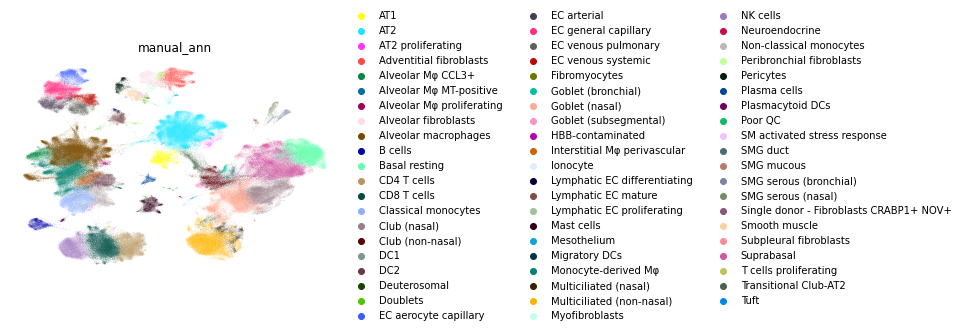

In [28]:
sc.pl.umap(adata_full, color="manual_ann", frameon=False)

if wanted, check if all cell types are represented by more than one donor (with at least 10 cells of the cell type)

In [29]:
counts_per_subj_per_ct = adata_full.obs.groupby(["manual_ann", "subject_ID"]).agg(
    {"subject_ID": "count"}
)

In [30]:
more_than_10_per_subj_per_ct = counts_per_subj_per_ct > 10

This shows the number of donors with at least 10 cells of the cell type:

In [31]:
more_than_10_per_subj_per_ct.unstack().sum(axis=1).sort_values()[:5]

manual_ann
Lymphatic EC proliferating                 1
Single donor - Fibroblasts CRABP1+ NOV+    1
SMG serous (nasal)                         3
Neuroendocrine                             4
Alveolar Mφ MT-positive                    4
dtype: int64

Now also add leveled annotations for each cell (i.e. from level 1 to level 5 for every cell, based on final annotation which is somewhere in the hierarchy):

In [32]:
for lev in range(1, 6):
    man_ann_to_lev_mapper = {
        manann: levann
        for manann, levann in zip(
            final_anns_to_leveled_anns_df.index,
            final_anns_to_leveled_anns_df[f"Level_{lev}"],
        )
    }
    # delete old colors
    if f"ann_level_{lev}_colors" in adata_full.uns.keys():
        del adata_full.uns[f"ann_level_{lev}_colors"]
    adata_full.obs[f"ann_level_{lev}"] = adata_full.obs.manual_ann.map(
        man_ann_to_lev_mapper
    )

add clean annotations (without forward propagation of lower levels) and remove forward-propagated labels:

In [33]:
adata_full = reference_based_harmonizing.add_clean_annotation(adata_full)

In [34]:
for lev in range(1, 6):
    del adata_full.obs[f"ann_level_{lev}"]
    adata_full.obs.rename(
        columns={f"ann_level_{lev}_clean": f"ann_level_{lev}"}, inplace=True
    )

Remove "Unicorns and Artefacts" (i.e. doublets, low QC etc.):

In [35]:
n_cells_before = adata_full.n_obs

In [ ]:
adata_full = adata_full[
    adata_full.obs.ann_level_1 != "Unicorns_and_artefacts", :
].copy()

In [ ]:
n_cells_after = adata_full.n_obs

In [ ]:
print("Cells removed:", n_cells_before - n_cells_after)

### Re-embed (neighbor graph and umap) after removing cells based on manual annotations (incl. e.g. doublets):

In [ ]:
sc.pp.neighbors(adata_full, n_neighbors=30, use_rep="X_scanvi_emb")

In [ ]:
sc.tl.umap(adata_full)

In [ ]:
adata_full.obsm["X_umap_scanvi"] = adata_full.obsm["X_umap"]

In [ ]:
sc.pl.umap(
    adata_full,
    color=[f"ann_level_{n}" for n in range(1, 6)],
    frameon=False,
    ncols=1,
)

### Add manual annotation coarse:

This annotation, which was also determined manually, is a coarsified version of the final annotations, and will be used for e.g. GWAS mapping to HLCA cell types, and modeling of effects of age, sex etc. on cell types. Each of these coarse annotations is part of the 5-level hierarchical cell-type reference.

In [ ]:
fine_ann_to_coarse = {
    fine: coarse
    for fine, coarse in zip(manual_annot.final_ann, manual_annot.final_ann_coarse)
}

sanity check: check if there's not an accidental one-to-many mapping:

In [ ]:
for fine, coarse in zip(manual_annot.final_ann, manual_annot.final_ann_coarse):
    if fine_ann_to_coarse[fine] != coarse:
        print(
            f"There's a one-to-many mapping, check this! Fine: {fine}, coarse: {coarse}"
        )

Add coarse annotations to adata:

In [ ]:
adata_full.obs["manual_ann_grouped"] = adata_full.obs.manual_ann.map(fine_ann_to_coarse)

And plot:

In [ ]:
sc.pl.umap(adata_full, color="manual_ann_grouped")

### Generate colors for all manual annotations, and store:

Delete existing color map, as this was generated (for umap above) for all manual annotations, including low QC and doublet clusters. We can generate a color map with fewer colors after removing the cells above.

In [ ]:
del adata_full.uns["manual_ann_colors"]

Order the remaining manual annotations (i.e. not the doublets etc.) in a biologically sensible order, i.e. using the order of the hierarchical cell type reference.

In [ ]:
manual_ann_ordered = [
    manann
    for manann in final_anns_to_leveled_anns_df.index.tolist()
    if manann in adata_full.obs.manual_ann.unique()
]

Also re-order categories in manual ann adata column accordingly:

In [ ]:
adata_full.obs.manual_ann.cat.reorder_categories(manual_ann_ordered, inplace=True)

Do the same for the "grouped" manual annotations (i.e. the coarsified annotations), based on the ordered fine annotations:

In [ ]:
del adata_full.uns["manual_ann_grouped_colors"]

In [ ]:
manual_ann_grouped_ordered = list()
for manann in manual_ann_ordered:
    grouped_manann = fine_ann_to_coarse[manann]
    if not grouped_manann in manual_ann_grouped_ordered:
        manual_ann_grouped_ordered.append(grouped_manann)

In [ ]:
adata_full.obs.manual_ann_grouped.cat.reorder_categories(
    manual_ann_grouped_ordered, inplace=True
)

Plot umap for both, which autmoatically generated a colormap:

In [ ]:
sc.pl.umap(adata_full, color="manual_ann", frameon=False)

In [ ]:
sc.pl.umap(adata_full, color="manual_ann_grouped", frameon=False)

store color mapping in dataframe:

In [ ]:
colors = adata_full.uns["manual_ann_colors"]

In [ ]:
man_ann_to_color = {man_ann: col for man_ann, col in zip(manual_ann_ordered, colors)}

In [ ]:
final_anns_to_leveled_anns_df["colors"] = final_anns_to_leveled_anns_df.index.map(
    man_ann_to_color
)

In [ ]:
colors_grouped_manann = adata_full.uns["manual_ann_grouped_colors"]

In [ ]:
man_ann_grouped_to_color = {
    mananngr: col
    for mananngr, col in zip(manual_ann_grouped_ordered, colors_grouped_manann)
}

In [ ]:
mananngrouped_df = pd.DataFrame(index=manual_ann_grouped_ordered)
mananngrouped_df["color"] = mananngrouped_df.index.map(man_ann_grouped_to_color)

store order and colors of annotations

In [ ]:
# remove annotations that were discarded (e.g. "Doublets")
final_anns_to_leveled_anns_df = final_anns_to_leveled_anns_df.loc[
    [
        manann
        for manann in final_anns_to_leveled_anns_df.index
        if manann in adata_full.obs.manual_ann.unique()
    ],
    :,
]

In [ ]:
final_anns_to_leveled_anns_df.to_csv(path_man_anns_levd_and_colors)

In [ ]:
mananngrouped_df.to_csv(path_grouped_man_anns_levd_and_colors)

## Quantify re-annotations:

Check which cells, according to the manual reannotation, were correctly annotated, incorrectly annotated, or underannotated.

First, generate two empty dictionaries that will contain the mapping of the manual annotations to the leveled annotations, plus the level of each manual annotation in the hierarchical cell type reference. This will allow us to match the (harmonized) original with the final annotations.

In [ ]:
manann2refann = dict()
manann2level = dict()

check to which level the manual annotations mapped (also check for slight changes in writing, e.g. different capitalization or underscores versus spaces)

In [ ]:
for ct in adata_full.obs.manual_ann.unique():
    ct_found = False
    for level in [2, 3, 4, 5]:
        level_cts = adata_full.obs[f"ann_level_{level}"].unique()
        if not ct_found:
            for level_ct in level_cts:
                if ct.lower() == level_ct.lower():
                    manann2refann[ct] = level_ct
                    manann2level[ct] = level
                    ct_found = True
                elif ct.replace("_", " ").lower() == level_ct.lower():
                    manann2refann[ct] = level_ct
                    manann2level[ct] = level
                    ct_found = True
                elif ct.replace("_", " ").lower().strip("s") == level_ct.lower():
                    manann2refann[ct] = level_ct
                    manann2level[ct] = level
                    ct_found = True
    if ct_found == True:
        if manann2refann[ct] != ct:
            print(ct)
    if ct_found == False:
        print(f"{ct} not found")

function to determine the reannotation type for every cell. We distinguish four types: 
- "correctly annotated", i.e. the original annotation was at least as detailed as the final annotation, and corresponds to the final annotation at the final annotation's level.
- "underannotated, correct", i.e. the original annotation was less detailed than the final annotations, and corresponds to the final annotation at a lower level than the final annotation's level
- "underannotated, incorrect", i.e. the original annotation was less detailed than the final annotation, and does not correspond to the final annotation at that lower level (this will be called "misannotated in figures and paper)
- "misannotated", i.e. the original annotation was equally or more detailed than the final annotation, but does not corresond to the final annotation at the final annotation's level.

In [ ]:
def get_cell_reannotation_type(
    manann, refann, manann2refann, manann2level, consensus_df
):
    manann_matched = manann2refann[manann]
    if manann_matched == refann:
        # if manual annotation and original annotation are the same,
        # then return correctly annotated
        return "correctly annotated"
    elif refann[:2] in ["1_", "2_", "3_", "4_"]:
        # if the original annotation has a 1_, 2_ etc. prefix at the level
        # of the manual annotation, then it was not annotated at this level.
        # In that case, check if the annotation at lower levels was correct.
        refann_level = refann[0]
        # check what the annotation at the refann_level is for the manual
        # annotation.
        manann_at_refann_level = consensus_df.loc[
            f"{manann2level[manann]}_{manann_matched}", f"level_{refann_level}"
        ]
        # if the refann has the correct under-annotation, then return:
        if refann[2:] == manann_at_refann_level:
            return "underannotated, correct"
        # otherwise, it was misannotated
        else:
            return "underannotated, incorrect"
    # if manann does not match refann, but it doesn't have a prefix,
    # then it was misannotated
    else:
        return "misannotated"

Calculate "reannotation type" for all cells in the HLCA:

In [ ]:
adata_full.obs["reannotation_type"] = [
    get_cell_reannotation_type(
        manann=manann,
        refann=adata_full.obs.loc[cell, f"original_ann_level_{manann2level[manann]}"],
        manann2refann=manann2refann,
        manann2level=manann2level,
        consensus_df=consensus_df,
    )
    for cell, manann in zip(adata_full.obs.index, adata_full.obs.manual_ann)
]

And plot:

In [ ]:
sc.pl.umap(adata_full, color="reannotation_type")

### Store final adata:

In [ ]:
adata_full.write(path_output_HLCA)